# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself. Everyone will get slightly different results depending on their machine.

Writing performant code is extremely important in scientific computing, but also can often be quite mysterious and confusing.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
    - C implementations (optional, require gcc)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.09714586009025017
 0.5725627981587986
 0.45073068008936135
 0.020377973251862302
 0.1603462603304433
 0.3920683400047167
 0.7748489825061524
 0.9874575267228058
 0.16612243904156698
 0.2123244695179869
 0.8945315797597582
 0.11145252271374528
 0.82034714747105
 ⋮
 0.7363644474904936
 0.23347073001161855
 0.638227336281302
 0.21719876730198417
 0.9534797700274362
 0.9342267147581766
 0.005689600827402552
 0.3742203798563728
 0.04260067138645218
 0.9659081419362088
 0.4033992796261001
 0.9347504758749843

In [2]:
sum(a)

5.000121880293823e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.006206 seconds (1 allocation: 16 bytes)


5.000121880293823e6

In [4]:
@time sum(a)

  0.006838 seconds (1 allocation: 16 bytes)


5.000121880293823e6

In [5]:
@time sum(a)

  0.004929 seconds (1 allocation: 16 bytes)


5.000121880293823e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

In [7]:
using BenchmarkTools  

# 1. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [8]:
using Pkg; Pkg.add("PyCall")
using PyCall

In [9]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [10]:
pysum(a)

5.000121880293161e6

In [11]:
pysum(a) ≈ sum(a)

true

In [12]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     843.223 ms (0.00% GC)
  median time:      850.461 ms (0.00% GC)
  mean time:        852.799 ms (0.00% GC)
  maximum time:     870.426 ms (0.00% GC)
  --------------
  samples:          6
  evals/sample:     1

In [13]:
d = Dict()  # a "dictionary", i.e. an associative array
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 1 entry:
  "Python built-in" => 843.223

In [14]:
using Plots

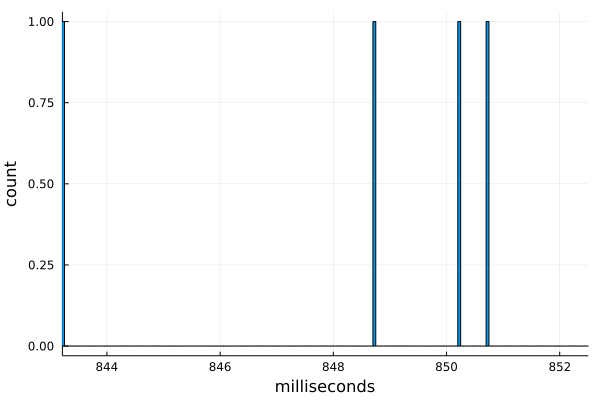

In [15]:
using Statistics # bring in statistical support for standard deviations
t = py_list_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [16]:
using Pkg; Pkg.add("Conda")
using Conda

In [19]:
Conda.add("numpy")
numpy_sum = pyimport("numpy")["sum"]


┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda C:\Users\yiann\.julia\packages\Conda\sNGum\src\Conda.jl:128


Solving environment: ...working... done

# All requested packages already installed.



PyObject <function sum at 0x0000000064261430>

In [20]:
numpy_sum(a)

5.000121880293827e6

In [21]:
numpy_sum(a) ≈ sum(a)# type \approx and then <TAB> to get the ≈ symbolb

true

In [22]:
≈  # alias for the `isapprox` function

isapprox (generic function with 18 methods)

In [23]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

---

```
isapprox(x::FixedPoint, y::FixedPoint; rtol=0, atol=max(eps(x), eps(y)))
```

For FixedPoint numbers, the default criterion is that `x` and `y` differ by no more than `eps`, the separation between adjacent fixed-point numbers.


In [24]:
py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     10.587 ms (0.00% GC)
  median time:      11.668 ms (0.00% GC)
  mean time:        11.883 ms (0.00% GC)
  maximum time:     15.634 ms (0.00% GC)
  --------------
  samples:          420
  evals/sample:     1

In [25]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 2 entries:
  "Python numpy"    => 10.587
  "Python built-in" => 843.223

### 3. Python, hand-written 

In [26]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x00000000640D8A60>

In [27]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     1.267 s (0.00% GC)
  median time:      1.307 s (0.00% GC)
  mean time:        1.303 s (0.00% GC)
  maximum time:     1.332 s (0.00% GC)
  --------------
  samples:          4
  evals/sample:     1

In [28]:
sum_py(a)

5.000121880293161e6

In [29]:
sum_py(a) ≈ sum(a)

true

In [30]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "Python numpy"        => 10.587
  "Python hand-written" => 1266.66
  "Python built-in"     => 843.223

# 4. Julia (built-in) 

## Written directly in Julia, not in C!

In [31]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:873

In [32]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.351 ms (0.00% GC)
  median time:      5.132 ms (0.00% GC)
  mean time:        5.321 ms (0.00% GC)
  maximum time:     8.536 ms (0.00% GC)
  --------------
  samples:          936
  evals/sample:     1

In [33]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "Python numpy"        => 10.587
  "Python hand-written" => 1266.66
  "Python built-in"     => 843.223
  "Julia built-in"      => 4.3513

# 5. Julia (hand-written) 

In [34]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [35]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     12.824 ms (0.00% GC)
  median time:      13.881 ms (0.00% GC)
  mean time:        13.949 ms (0.00% GC)
  maximum time:     16.299 ms (0.00% GC)
  --------------
  samples:          358
  evals/sample:     1

In [36]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "Python numpy"        => 10.587
  "Julia hand-written"  => 12.8237
  "Python hand-written" => 1266.66
  "Python built-in"     => 843.223
  "Julia built-in"      => 4.3513

# 6. Julia (hand-written w. simd) 

In [37]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [38]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.385 ms (0.00% GC)
  median time:      5.378 ms (0.00% GC)
  mean time:        5.720 ms (0.00% GC)
  maximum time:     12.822 ms (0.00% GC)
  --------------
  samples:          871
  evals/sample:     1

In [39]:
mysum_simd(a)

5.000121880293811e6

In [40]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "Julia hand-written simd" => 4.3853
  "Python numpy"            => 10.587
  "Julia hand-written"      => 12.8237
  "Python hand-written"     => 1266.66
  "Python built-in"         => 843.223
  "Julia built-in"          => 4.3513

In [42]:
?@simd

```
@simd
```

Annotate a `for` loop to allow the compiler to take extra liberties to allow loop re-ordering

!!! warning
    This feature is experimental and could change or disappear in future versions of Julia. Incorrect use of the `@simd` macro may cause unexpected results.


The object iterated over in a `@simd for` loop should be a one-dimensional range. By using `@simd`, you are asserting several properties of the loop:

  * It is safe to execute iterations in arbitrary or overlapping order, with special consideration for reduction variables.
  * Floating-point operations on reduction variables can be reordered, possibly causing different results than without `@simd`.

In many cases, Julia is able to automatically vectorize inner for loops without the use of `@simd`. Using `@simd` gives the compiler a little extra leeway to make it possible in more situations. In either case, your inner loop should have the following properties to allow vectorization:

  * The loop must be an innermost loop
  * The loop body must be straight-line code. Therefore, [`@inbounds`](@ref) is   currently needed for all array accesses. The compiler can sometimes turn   short `&&`, `||`, and `?:` expressions into straight-line code if it is safe   to evaluate all operands unconditionally. Consider using the [`ifelse`](@ref)   function instead of `?:` in the loop if it is safe to do so.
  * Accesses must have a stride pattern and cannot be "gathers" (random-index   reads) or "scatters" (random-index writes).
  * The stride should be unit stride.

!!! note
    The `@simd` does not assert by default that the loop is completely free of loop-carried memory dependencies, which is an assumption that can easily be violated in generic code. If you are writing non-generic code, you can use `@simd ivdep for ... end` to also assert that:


  * There exists no loop-carried memory dependencies
  * No iteration ever waits on a previous iteration to make forward progress.


# Summary

In [43]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia built-in..............4.4
Julia hand-written simd.....4.4
Python numpy...............10.6
Julia hand-written.........12.8
Python built-in...........843.2
Python hand-written......1266.7


# 7. The C language
C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

In [ ]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

In [ ]:
c_sum(a)

In [ ]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

In [ ]:
c_sum(a) - sum(a)

In [ ]:
c_bench = @benchmark c_sum($a)

In [ ]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

In [ ]:
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

# 8. C with -ffast-math
If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [ ]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

In [ ]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

In [ ]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

In [1]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

LoadError: UndefVarError: d not defined